# 1. 탐색적 데이터 분석 (EDA)

### 라이브러리 및 데이터 불러오기

In [ ]:
from geoband.API import *

In [ ]:
import folium
import json
import geopandas as gpd

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import haversine

from shapely.geometry import Point, Polygon, MultiPolygon

import platform

from IPython.display import set_matplotlib_formats

if platform.system() == 'Darwin':
    plt.rc('font', family = 'AppleGothic')
elif platform.system() == 'Windows':
    plt.rc('font', family = 'Malgun Gothic')

plt.rc('axes', unicode_minus=False)

set_matplotlib_formats('retina')

import warnings
warnings.filterwarnings(action='ignore')

import pathlib
from tqdm import tqdm, notebook
import os

%matplotlib inline

In [ ]:
# 데이터 불러오기
input_path = pathlib.Path('./data')
if not input_path.is_dir():
    input_path.mkdir()

GetCompasData('SBJ_2009_001', '1', input_path.joinpath('01.광양시_충전소설치현황.csv'))
GetCompasData('SBJ_2009_001', '3', input_path.joinpath('03.광양시_자동차등록현황_격자(100X100).geojson'))
GetCompasData('SBJ_2009_001', '6', input_path.joinpath('06.광양시_전기차보급현황(연도별,읍면동별).csv'))
GetCompasData('SBJ_2009_001', '7', input_path.joinpath('07.광양시_법정동별_인구현황(읍면동리).csv'))
GetCompasData('SBJ_2009_001', '8', input_path.joinpath('08.광양시_격자별인구현황(100X100).geojson'))
GetCompasData('SBJ_2009_001', '10', input_path.joinpath('10.광양시_상세도로망_LV6.geojson'))
GetCompasData('SBJ_2009_001', '11', input_path.joinpath('11.광양시_평일_일별_시간대별__추정교통량_LV6.csv'))
GetCompasData('SBJ_2009_001', '20', input_path.joinpath('20.광양시_행정경계(읍면동).geojson'))

# 국토정보맵 데이터
생산가능인구수 = gpd.read_file('./data/생산가능인구수/vl_blk.shp', encoding = 'EUC-KR')
주차장접근성 = gpd.read_file('./data/주차장접근성/주차장접근성.shp')

# COMPAS 데이터
충전소설치현황 = pd.read_csv('./data/01.광양시_충전소설치현황.csv')
자동차등록현황 = gpd.read_file('./data/03.광양시_자동차등록현황_격자(100X100).geojson')
전기차보급현황 = pd.read_csv('./data/06.광양시_전기차보급현황(연도별,읍면동별).csv')
인구현황 = pd.read_csv('./data/07.광양시_법정동별_인구현황(읍면동리).csv')
격자별인구현황 = gpd.read_file('./data/08.광양시_격자별인구현황(100X100).geojson')
상세도로망 = gpd.read_file('./data/10.광양시_상세도로망_LV6.geojson')
추정교통량 = pd.read_csv('./data/11.광양시_평일_일별_시간대별__추정교통량_LV6.csv')
행정경계 = gpd.read_file('./data/20.광양시_행정경계(읍면동).geojson')

## 1.1. 충전소설치현황

In [ ]:
충전소설치현황.head()

In [ ]:
# 기존 설치된 충전소 지도 표시
center = (34.940710, 127.695920) # 광양시 시청 기준
zoom = 11
광양시_지도 = folium.Map(location = center,
                       zoom_start = zoom,
                    tiles='http://api.vworld.kr/req/wmts/1.0.0/7C5AEFC9-57EF-35BD-A78A-74C1DD916554/Base/{z}/{y}/{x}.png',
                    attr='My Data Attribution')
folium.GeoJson(행정경계).add_to(광양시_지도)

for i in 충전소설치현황.index:
    popup_name = 충전소설치현황['충전소명'][i] + '-' + 충전소설치현황['급속/완속'][i]
    if 충전소설치현황['급속/완속'][i] == '급속':
        icon_color = 'red' # 급속: 빨강
    else:
        icon_color = 'green' # 완속: 초록
    
    folium.Marker(
        location = (충전소설치현황['lat'][i], 충전소설치현황['lon'][i]),
        popup = popup_name,
        icon = folium.Icon(color=icon_color)
    ).add_to(광양시_지도)

광양시_지도

- 도심지 위주로 충전소들이 설치되어 있음 (중마동, 광양읍, 광영동, 금호동, 태인동)

## 1.2. 전기차보급현황

In [ ]:
전기차보급현황.head()

In [ ]:
print('총 전기차 보급 현황: {}'.format(전기차보급현황['보급현황'].sum()))

In [ ]:
전기차보급현황.groupby(['행정구역'])['보급현황'].sum().sort_values(ascending=False)

In [ ]:
전기차보급현황.groupby(['행정구역'])['보급현황'].sum().sort_values(ascending=False).plot(kind = 'bar', title = '행정구역별 전기차 보급 현황', figsize=(10,6))
plt.show()

- 광양읍과 중마동에 전기차 보급이 집중되어 있음

In [ ]:
print('총 자동차 등록 현황: {}'.format(자동차등록현황['totale'].sum()))

In [ ]:
print('전기차 비중: {:.3f}%'.format((253/15862*100)))

## 1.3. 자동차등록현황

In [ ]:
자동차등록현황

In [ ]:
# 자동차등록현황 지도 표시
center = (34.940710, 127.695920) # 광양시 시청 기준
zoom = 11
광양시_지도 = folium.Map(location = center,
                       zoom_start = zoom,
                    tiles='http://api.vworld.kr/req/wmts/1.0.0/7C5AEFC9-57EF-35BD-A78A-74C1DD916554/Base/{z}/{y}/{x}.png',
                    attr='My Data Attribution')
folium.GeoJson(행정경계).add_to(광양시_지도)

# 1개 이상의 자동차가 등록된 지역
자동차_nonzero = 자동차등록현황.loc[자동차등록현황['totale'] !=0]
folium.Choropleth(
    geo_data = 자동차_nonzero,
    data = 자동차_nonzero,
    columns=['id', 'totale'],
    key_on='feature.properties.id',
    fill_color='YlGnBu'
).add_to(광양시_지도)

광양시_지도

- 전기차와 마찬가지로 광양읍과 중마동에 차량이 집중되어 있음.

## 1.4. 인구현황

In [ ]:
인구현황.head()

In [ ]:
인구현황.groupby(['읍면동'])['계'].sum().sort_values(ascending=False)

In [ ]:
인구현황.groupby(['읍면동'])['계'].sum().sort_values(ascending=False).plot(kind = 'bar', title = '법정도별 인구 현황', figsize=(10,6))
plt.show()

- 광양읍과 중마동 두 지역에 인구와, 자동차, 전기차, 충전소가 밀집되어 있음
- 밀집도가 어느정도 충전소 설치에 영향을 미칠 것이라 생각함

## 1.5. 교통량

In [ ]:
추정교통량.head()

In [ ]:
상세도로망['link_id'], 추정교통량['상세도로망_링크ID']

- 추정교통량의 '상세도로망_링크ID' 뒤에 붙는 01, 02의 의미는 각각 상행, 하행을 나타냄.
- 도로등급이 '고속도로'인 경우 상,하행과 관련없이 대부분 01로 구분.
- __상세도로망의 'link_id'와 매칭시키기 위해서는 뒤에 두 자릿수를 빼야함.__

In [ ]:
추정교통량['시간적범위'].unique()

- '시간적범위'의 데이터 타입이 섞여있음

In [ ]:
#데이터 타입 string으로 통일
추정교통량['시간적범위'] = 추정교통량['시간적범위'].astype(str)
추정교통량['시간적범위'].unique()

- 전일과, 0~23시의 시간적범위가 있음.
- __전체 교통량이 중요하기에 '전일'만 사용.__

In [ ]:
추정교통량['평일주말'].unique()

- '평일주말'엔 평일만 있음

- 승용차, 버스, 화물차의 교통량을 모두 더한 '전체' 컬럼만 사용.
- __필요한 컬럼: ['상세도로망_링크ID', '시간적_범위', '전체']__

In [ ]:
# 상세도로망_링크ID 가공
추정교통량['상세도로망_링크ID'] = 추정교통량['상세도로망_링크ID'].astype(str)
추정교통량['link_id'] = 추정교통량['상세도로망_링크ID'].str.slice(start = 0, stop = 9)
추정교통량.drop('상세도로망_링크ID', axis = 1, inplace = True)

추정교통량 = 추정교통량.groupby(['link_id'])['전체'].sum().to_frame()
추정교통량.reset_index(level = ['link_id'], inplace = True)

In [ ]:
추정교통량['link_id']

In [ ]:
# 상세도로망 데이터와 추정교통량 데이터 합치기
추정교통량['link_id'] = 추정교통량['link_id'].astype(str)
교통량_gdf = pd.merge(상세도로망, 추정교통량, on = 'link_id', how = 'left')
교통량_gdf = 교통량_gdf[['link_id', '전체', 'geometry']]
# '전체' column명을 '교통량'으로 변경
교통량_gdf.rename(columns = {'전체':'교통량'}, inplace = True)

### 격자 데이터에 교통량 데이터 표현
- 생산가능인구수의 격자 사용

In [ ]:
# 생산가능인구수의 좌표계를 EPSG:4326으로 변환함
생산가능인구수 = 생산가능인구수.to_crs({'init': 'epsg:4326'})

In [ ]:
# 도로가 지나가는 격자에 교통량 데이터 입력
생산가능인구수['교통량'] = 0
for i in tqdm(교통량_gdf.index):
    for j in 생산가능인구수.index:
        if 교통량_gdf['geometry'][i].intersects(생산가능인구수['geometry'][j]):
            생산가능인구수['교통량'][j] += 교통량_gdf['교통량'][i]

In [ ]:
# 교통량 지도에 표시
center = (34.940710, 127.695920) # 광양시 시청 기준
zoom = 11
광양시_지도 = folium.Map(location = center,
                       zoom_start = zoom,
                    tiles='http://api.vworld.kr/req/wmts/1.0.0/7C5AEFC9-57EF-35BD-A78A-74C1DD916554/Base/{z}/{y}/{x}.png',
                    attr='My Data Attribution')

folium.Choropleth(
    geo_data = 생산가능인구수,
    data = 생산가능인구수,
    columns=['gid', '교통량'],
    key_on='feature.properties.gid',
    fill_color = 'YlGnBu'
).add_to(광양시_지도)
광양시_지도

## 1.6. 주차장접근성

In [ ]:
# 주차장접근성 데이터에서 광양시 데이터만 추출
주차장접근성_광양 = 주차장접근성[주차장접근성['sgg_nm_e'] == 'Gwangyang-si']
주차장접근성_광양.reset_index(inplace = True)

# 주차장접근성_광양 좌표계 변환
주차장접근성_광양 = 주차장접근성_광양.to_crs({'init': 'epsg:4326'})

In [ ]:
# 주차장접근성 지도에 표시
center = (34.940710, 127.695920) # 광양시 시청 기준
zoom = 11
광양시_지도 = folium.Map(location = center,
                       zoom_start = zoom,
                    tiles='http://api.vworld.kr/req/wmts/1.0.0/7C5AEFC9-57EF-35BD-A78A-74C1DD916554/Base/{z}/{y}/{x}.png',
                    attr='My Data Attribution')

folium.Choropleth(
    geo_data = 주차장접근성_광양,
    data = 주차장접근성_광양,
    columns=['gid', 'value'],
    key_on='feature.properties.gid',
    fill_color = 'YlGnBu'
).add_to(광양시_지도)
광양시_지도

- 주차장접근성은 격자 중심점으로부터 가장 가까운 주차장까지 도로 이동거리이므로, 클수록 접근성이 좋지 않은 것
- 도심지역일수록 주차장 접근성이 대체로 좋음

# 2. 의사결정요소 Feature engineering

## 2. 의사결정요소 1 : 밀집도
### 생산가능인구수
- 국토정보플랫폼 국토정보맵 국토통계지도(http://map.ngii.go.kr/ms/map/NlipMap.do)의 격자별 생산가능인구수 데이터(250X250) 사용 

### 자동차보유*전기차비율
- 제공된 데이터는 100X100 격자 기준이나, 타 요소와의 격자 통일을 위해 처리함(250X250)
- Null 값은 존재하지 않으나 0값이 대부분을 차지하고 있어, 데이터 변환의 수월성을 위해 0값을 제거함
- 전기차보급현황 데이터를 통해 계산한 행정구역별 전기차 보급 비율을 자동차등록현황에 곱해줌

### 토지이용압축도
- 격자 내 건축물 연면적 합 ÷ 격자 면적 × 100

### 데이터 불러오기

In [ ]:
# 데이터 불러오기
input_path = pathlib.Path('./data')
if not input_path.is_dir():
    input_path.mkdir()


GetCompasData('SBJ_2009_001', '3', input_path.joinpath('03.광양시_자동차등록현황_격자(100X100).geojson'))
GetCompasData('SBJ_2009_001', '6', input_path.joinpath('06.광양시_전기차보급현황(연도별,읍면동별).csv'))
GetCompasData('SBJ_2009_001', '15', input_path.joinpath('15.광양시_건물정보.geojson'))
GetCompasData('SBJ_2009_001', '20', input_path.joinpath('20.광양시_행정경계(읍면동).geojson'))

# 국토정보맵 데이터
생산가능인구수 = gpd.read_file('./data/생산가능인구수/vl_blk.shp', encoding = 'EUC-KR')

# COMPAS 데이터
자동차등록현황 = gpd.read_file('./data/03.광양시_자동차등록현황_격자(100X100).geojson')
전기차보급현황 = pd.read_csv('./data/06.광양시_전기차보급현황(연도별,읍면동별).csv')
건물정보 = gpd.read_file('./data/15.광양시_건물정보.geojson')
행정경계_읍면동 = gpd.read_file('./data/20.광양시_행정경계(읍면동).geojson')

### 생산가능인구수

In [ ]:
# 생산가능인구수의 좌표계를 EPSG:4326으로 변환함
생산가능인구수 = 생산가능인구수.to_crs({'init': 'epsg:4326'})

# feature_gdf 데이터 프레임에 밀집도 feature 취합함
feature_gdf = 생산가능인구수.drop('lbl', axis = 1).rename(columns = {'val':'생산가능인구수'}).copy()

### 자동차보유*전기차비율

In [ ]:
# 자동차등록현황 250X250 격자화 및 feature_gdf에 취합
feature_gdf['자동차등록현황'] = 0
자동차등록현황 = 자동차등록현황[자동차등록현황['totale'] != 0]

for i in tqdm(자동차등록현황.index):
    for j in feature_gdf.index:
        if 자동차등록현황['geometry'][i].intersects(feature_gdf['geometry'][j]):
            feature_gdf['자동차등록현황'][j] += 자동차등록현황['totale'][i]

- 자동차등록현황에 광양시 전기차 비율 반영

In [ ]:
# 전기차보급현황의 행정경계 표시하기 위해 dataframe merge
전기차보급현황 = 전기차보급현황.groupby('행정구역')[['보급현황']].sum()
전기차보급현황 = pd.merge(행정경계_읍면동, 전기차보급현황, left_on = 'ADM_DR_NM', right_on = '행정구역')
전기차보급현황 = 전기차보급현황.rename(columns = {'ADM_DR_NM' : '행정구역'})[['행정구역', '보급현황', 'geometry']]

In [ ]:
%%time
ft2 = feature_gdf.copy()
ft2['행정구역'] = 'NaN'

# 격자에 데이터 넣기
for i in range(len(ft2)):
    point = ft2['geometry'][i].centroid
    for j in range(len(전기차보급현황)):
        if (point.within(전기차보급현황['geometry'][j])):           #격자의 centroid가 행정경계 안에 있으면 행정구역명 넣기
            ft2['행정구역'][i] = 전기차보급현황['행정구역'][j]
            break
        elif (ft2['geometry'][i].intersects(전기차보급현황['geometry'][j])):     #경계에 걸쳐있어 null값으로 처리되는 데이터는 intersects로 겹치면 행정구역명 넣기
            ft2['행정구역'][i] = 전기차보급현황['행정구역'][j]
            break

In [ ]:
# 처리되지 않는 null값은 따로 처리(3건)
ft2['행정구역'][1212] = '광양읍'
ft2['행정구역'][1213] = '광양읍'
ft2['행정구역'][7606] = '태인동'

In [ ]:
# 전기차보급현황 dataframe에 행정구역별 전기차 보급 비율 계산해서 추가
df = ft2.groupby('행정구역')[['자동차등록현황']].sum()
df2 = pd.merge(df, 전기차보급현황, on = '행정구역')
df2['보급비율'] = df2['보급현황']/df2['자동차등록현황']
df2

In [ ]:
%%time
ft2['자동차보유*전기차비율'] = ft2['자동차등록현황'].astype(float)

for i in range(len(ft2)):
    for j in range(len(df2)):
        if (ft2['행정구역'][i] == df2['행정구역'][j]):
            ft2['자동차보유*전기차비율'][i] =  ft2['자동차보유*전기차비율'][i]*df2['보급비율'][j]
            break

# feature_gdf에 취합
feature_gdf['자동차보유*전기차비율'] = ft2['자동차보유*전기차비율']
feature_gdf.drop('자동차등록현황', axis=1, inplace=True)

### 토지이용압축도

In [ ]:
# 건물정보 데이터를 활용하여 격자 내 연면적 합 구하기
건물정보_연면적 = 건물정보[['건물연면적','geometry']]

feature_gdf['연면적'] = 0

for i in tqdm(건물정보_연면적.index):
    point = 건물정보_연면적['geometry'][i].centroid
    for j in feature_gdf.index:
        if(point.within(feature_gdf['geometry'][j])):
            feature_gdf['연면적'][j] += 건물정보_연면적['건물연면적'][i]

In [ ]:
# 토지이용압축도 구하기 (격자 내 건축물 연면적 합 ÷ 격자 면적 × 100)
feature_gdf['토지이용압축도'] = feature_gdf['연면적']/62500 * 100
feature_gdf.drop('연면적', axis=1, inplace=True)

In [ ]:
# feature_gdf 저장
feature_gdf.to_file('./data/feature_gdf.geojson', driver = 'GeoJSON')

## 3. 의사결정요소 2 : 접근성
### 교통량
- 추정교통량 '상세도로망_링크ID'와 
- 승용차, 버스, 화물차의 교통량을 모두 더한 '전체' 컬럼만 사용

### 주차장 접근성
- 격자 중심점으로부터 가장 가까운 주차장까지 도로 이동거리
- 국토정보플랫폼 국토정보맵 국토통계지도(http://map.ngii.go.kr/ms/map/NlipMap.do)의 격자별 주차장접근성 데이터(500X500) 사용
- feature_gdf의 250X250 격자를 기준으로 가공 

### 주차장 흡인력
- 허프 확률 모형을 이용하여 주차장이 사람을 유인하는 힘인 주차장 흡인력을 계산함
- 주차장 격자로부터 거리가 가까우면 흡인력이 강함
- 주차장 면적이 넓을수록 흡인력이 강함
- 광양시에 있는 모든 주차장은 모든 격자의 영향을 미칠수 있다고 가정

### 데이터 불러오기

In [ ]:
# 데이터 불러오기
input_path = pathlib.Path('./data')
if not input_path.is_dir():
    input_path.mkdir()

GetCompasData('SBJ_2009_001', '2',  input_path.joinpath('02.광양시_주차장_공간정보.csv'))
GetCompasData('SBJ_2009_001', '10', input_path.joinpath('10.광양시_상세도로망_LV6.geojson'))
GetCompasData('SBJ_2009_001', '11', input_path.joinpath('11.광양시_평일_일별_시간대별__추정교통량_LV6.csv'))

# 국토정보맵 데이터
주차장접근성 = gpd.read_file('./data/주차장접근성/주차장접근성.shp', encoding = 'euc-kr')

# COMPAS 데이터
주차장 = pd.read_csv('./data/02.광양시_주차장_공간정보.csv')
상세도로망 = gpd.read_file('./data/10.광양시_상세도로망_LV6.geojson')
추정교통량 = pd.read_csv('./data/11.광양시_평일_일별_시간대별__추정교통량_LV6.csv')

# feature_gdf
feature_gdf = gpd.read_file('./data/feature_gdf.geojson')

### 교통량

In [ ]:
# 추정교통량 '시간적범위'의 데이터 타입을 string으로 통일
추정교통량['시간적범위'] = 추정교통량['시간적범위'].astype(str)

# 시간적_범위 '전일' 추출 및 필요 컬럼만 추출
추정교통량 = 추정교통량[추정교통량['시간적범위'] == '전일']
추정교통량 = 추정교통량[['상세도로망_링크ID','전체']]

# 상세도로망_링크ID 가공(상세도로망 'link_id'과 매칭시키기 위해  상행/하행을 의미하는 두 개 숫자 제거)
추정교통량['상세도로망_링크ID'] = 추정교통량['상세도로망_링크ID'].astype(str)
추정교통량['link_id'] = 추정교통량['상세도로망_링크ID'].str.slice(start = 0, stop = 9)
추정교통량.drop('상세도로망_링크ID', axis = 1, inplace = True)

추정교통량 = 추정교통량.groupby(['link_id'])['전체'].sum().to_frame()
추정교통량.reset_index(level = ['link_id'], inplace = True)

# 상세도로망과 추정교통량 병합
교통량 = pd.merge(상세도로망, 추정교통량, on = 'link_id', how = 'left')
교통량 = 교통량[['link_id', '전체', 'geometry']]
교통량.rename(columns = {'전체':'교통량'}, inplace = True)

In [ ]:
# 도로가 지나가는 격자에 교통량 데이터 입력
feature_gdf['교통량'] = 0
for i in tqdm(교통량.index):
    for j in feature_gdf.index:
        if 교통량['geometry'][i].intersects(feature_gdf['geometry'][j]):
            feature_gdf['교통량'][j] += 교통량['교통량'][i]

### 주차장 접근성

In [ ]:
# 주차장접근성 데이터에서 광양시 데이터만 추출
주차장접근성_광양 = 주차장접근성[주차장접근성['sgg_nm_e'] == 'Gwangyang-si']
주차장접근성_광양.reset_index(inplace = True)

# 주차장접근성_광양 좌표계 변환
주차장접근성_광양 = 주차장접근성_광양.to_crs({'init': 'epsg:4326'})

In [ ]:
#주차장접근성 float로 추가
feature_gdf['주차장접근성'] = 0.0
for i in tqdm(주차장접근성_광양.index):
    for j in feature_gdf.index:
        if 주차장접근성_광양['geometry'][i].intersects(feature_gdf['geometry'][j]):
            feature_gdf['주차장접근성'][j] += 주차장접근성_광양['value'][i]

In [ ]:
# 주차장접근성의 값이 클수록 접근성이 좋지 않으므로, 음수로 취함.
feature_gdf['주차장접근성'] = -(feature_gdf['주차장접근성'])

### 주차장 흡인력

In [ ]:
주차장.isnull().sum()

- 주차장 면적보다 상대적으로 null값이 적은 주차면수를 활용

In [ ]:
# 주차장 흡인력을 계산하는 함수
def parking_power(geometry):
    lat, lon = geometry.centroid.coords[0][1], geometry.centroid.coords[0][0]
    
    total_주차면수 = 0
    for i in range(M):
        주차면수 = 주차장.loc[i, '주차면수']
        y, x = 주차장.loc[i,['lon','lat']].values
        거리 = haversine.haversine((x,y),(lat,lon))

        if not(주차면수 != 주차면수):
            total_주차면수 += (주차면수/(거리))

    return total_주차면수

In [ ]:
N = len(feature_gdf)
M = len(주차장)

for i in tqdm(range(N)):
    geometry = feature_gdf.loc[i, 'geometry']
    feature_gdf.loc[i, '주차장흡인력'] = parking_power(geometry)

In [ ]:
# feature_gdf 저장
feature_gdf.to_file('./data/feature_gdf.geojson', driver = 'GeoJSON')

# 4. 데이터 전처리

### 데이터 불러오기

In [ ]:
# 데이터 불러오기
input_path = pathlib.Path('./data')
if not input_path.is_dir():
    input_path.mkdir()

GetCompasData('SBJ_2009_001', '1', input_path.joinpath('01.광양시_충전소설치현황.csv'))

# COMPAS 데이터
충전소설치현황 = pd.read_csv('./data/01.광양시_충전소설치현황.csv')

# feature_gdf
feature_gdf = gpd.read_file('./data/feature_gdf.geojson')

## 4.1. MinMaxScaler
- feature별로 상위 30퍼센트 격자만 추출
- 즉, feature별로 상위 30퍼센트 격자들의 교집합만 고려
- 충분히 40개 이상은 뽑을 수 있음

In [ ]:
def MinMaxScaler(values):
    min_value = values.min()
    max_value = values.max()
    return (values-min_value)/(max_value - min_value)

In [ ]:
features = ['생산가능인구수', '자동차보유*전기차비율', '토지이용압축도', 
            '교통량', '주차장접근성', '주차장흡인력']
의사결정요소 = ['밀집도', '접근성']

In [ ]:
# feature 별로 상위 30퍼센트 뽑아서 minmaxscale

scale_df = feature_gdf[['gid', 'geometry']]
for feature in features:
    print(f'0이 아닌 {feature} 의 갯수 :',feature_gdf[feature_gdf[feature] != 0][feature].count())
    temp = feature_gdf[feature_gdf[feature] != 0][feature].quantile(0.7)
    print(f'{feature}의 상위 30퍼 갯수 :',feature_gdf[feature_gdf[feature] >= temp][feature].count(), '\n')
    scale_df = pd.merge(scale_df, MinMaxScaler(feature_gdf[feature_gdf[feature] >= temp][feature]).to_frame(), left_index = True, right_index = True, how = 'left')

scale_df = scale_df.fillna(0)

In [ ]:
# 의사결정요소를 각 feature를 합해서 구함
for i in range(2):
    scale_df[의사결정요소[i]] = scale_df[features[3*i]] + scale_df[features[3*i+1]] + scale_df[features[3*i+2]]

scale_df

In [ ]:
img1 = Image.open('./data/image1.png')
plt.figure(figsize=(16,10))
plt.imshow(img1)
img2 = Image.open('./data/image2.png')
plt.figure(figsize=(16,10))
plt.imshow(img2)
img3 = Image.open('./data/image3.png')
plt.figure(figsize=(16,10))
plt.imshow(img3)
plt.show()

## 4.2. 가중치 추정

- eigenvalue method사용
- 큰 의사결정요소부터 계산 후, 세부 의사결정요소 계산
- 기존 설치된 충전기의 feature 값의 평균을 비율로 계산해서 점수를 1~5로 나눔


### 점수 부여 방식
- 1 ~ 1.25 -> 1
- 1.25 ~ 1.5 -> 2
- 1.5 ~ 1.75 -> 3
- 1.75 ~ 2 -> 4
- 2이상 -> 5


### 계산 과정
- 행렬을 A라하면 A * A 내적을 해준 다음 열방향으로 더함
- 더한 값을 전체 합으로 나눠줘서 각각을 가중치로 사용

In [ ]:
def Eigenvalue_Method(df):
    def cal_eigenvalue(cate, matrix):
        N = len(matrix)
        for i in range(N):
            for j in range(N):
                if matrix[i][j]:   # 이미 점수가 부여됬을 경우
                    continue
                if i==j:           # 같은 feature는 1점 부여
                    matrix[i][j] = 1
                    continue
                a, b = cate[i], cate[j]
                if a < b:
                    a, b = b, a
                    i, j = j,i
                
                # 평균비율 계산후 점수를 1~5점 부여
                if a / b < 1.25:
                    matrix[i][j] = 1
                    matrix[j][i] = 1
                elif a / b < 1.5:
                    matrix[i][j] = 2
                    matrix[j][i] = 1/2
                elif a / b < 1.75:
                    matrix[i][j] = 3
                    matrix[j][i] = 1/3
                elif a / b < 2:
                    matrix[i][j] = 4
                    matrix[j][i] = 1/4
                else:
                    matrix[i][j] = 5
                    matrix[j][i] = 1/5
            eigen_matrix = np.dot(np.array(matrix), np.array(matrix))
            eigen_vector = eigen_matrix.sum(axis = 1)
            eigen_vector = eigen_vector / eigen_vector.sum()

        return eigen_vector
    
    big_matrix = [[0 for i in range(2)] for i in range(2)]
    matrix1 = [[0 for i in range(3)] for i in range(3)]
    matrix2 = [[0 for i in range(3)] for i in range(3)]
    
    big_cate = []
    for cate in 의사결정요소:
        big_cate.append(df[cate].mean())
    
    small_cate = []
    for feature in features:
        small_cate.append(df[feature].mean())

    b_eigen_vector = cal_eigenvalue(big_cate, big_matrix)
        
    eigen_vector1 = cal_eigenvalue(small_cate[:3], matrix1)
    eigen_vector2 = cal_eigenvalue(small_cate[3:6], matrix2)
    
    total_eigenvalue = np.array([])
    total_eigenvalue = np.hstack([total_eigenvalue, b_eigen_vector[0] * eigen_vector1])
    total_eigenvalue = np.hstack([total_eigenvalue, b_eigen_vector[1] * eigen_vector2])
    
    return total_eigenvalue

In [ ]:
N = len(scale_df)
M = len(충전소설치현황)

# 완,급속 충전기 있는 좌표만 뽑음
완속충전장소매핑 = {}
급속충전장소매핑 = {}

for i in tqdm(range(M)):
    급완 = 충전소설치현황.loc[i, '급속/완속']
    충전장소 = Point(충전소설치현황.loc[i,['lon','lat']].values)

    for j in range(N):
        if 충전장소.within(scale_df.loc[j, 'geometry']):
            if 급완 == '완속':
                완속충전장소매핑[i] = j
                # print(f"{i}번째 완속 충전기는 scale_df의 {j}번째 인덱스에 있음!!")
                break
            else:
                급속충전장소매핑[i] = j
                # print(f"{i}번째 완속 충전기는 scale_df의 {j}번째 인덱스에 있음!!")
                break

In [ ]:
완속_df = scale_df.loc[완속충전장소매핑.values()]
급속_df = scale_df.loc[급속충전장소매핑.values()]

완속가중치 = Eigenvalue_Method(완속_df)
급속가중치 = Eigenvalue_Method(급속_df)

scale_df['완속_score'] = 0
scale_df['급속_score'] = 0

for i in range(6):
    scale_df['완속_score'] += scale_df[features[i]]*완속가중치[i]
    scale_df['급속_score'] += scale_df[features[i]]*급속가중치[i]

In [ ]:
# 완속가중치
for i in range(6):
    print(features[i], '     ',완속가중치[i])
    if i%3==2:
        print()

In [ ]:
# 급속가중치
for i in range(6):
    print(features[i], '     ',급속가중치[i])
    if i%3==2:
        print()

## 4.3. 충전기 커버 지수

## 거리를 이용해 충전기가 커버할수 있는 격자별 점수를 영향력 개념으로 선정

- 충전기격자로부터 거리가 가까우면 영향력이 높음
- 광양시에 있는 모든 충전기는 모든 격자의 영향을 미칠수 있다고 가정
- 충전기의 이용 대수는 영향력의 비례함
- 거리의 역수를 이용

In [ ]:
def charger_cover(geometry, slow = False):
    lat, lon = geometry.centroid.coords[0][1], geometry.centroid.coords[0][0]
    
    total = 0
    for i in range(M):
        급완 = 충전소설치현황.loc[i, '급속/완속']
        if not slow and 급완 == '완속':
            continue
        
        이용대수 = 충전소설치현황.loc[i, '이용대수']
        y, x = 충전소설치현황.loc[i,['lon','lat']].values
        거리 = haversine.haversine((x,y),(lat,lon))
        total += (이용대수/(거리))
    return total

In [ ]:
for i in range(N):
    geometry = scale_df.loc[i, 'geometry']
    scale_df.loc[i, '완속_cover'] = charger_cover(geometry, slow = True)
    scale_df.loc[i, '급속_cover'] = charger_cover(geometry, slow = False)

scale_df['완속_cover_scale'] = MinMaxScaler(scale_df['완속_cover'])+1
scale_df['급속_cover_scale'] = MinMaxScaler(scale_df['급속_cover'])+1

scale_df['완속_scale_score'] = scale_df['완속_score'] * (1/scale_df['완속_cover_scale'])
scale_df['급속_scale_score'] = scale_df['급속_score'] * (1/scale_df['급속_cover_scale'])

In [ ]:
# scale_df 저장
scale_df.to_file('./data/scale_df.geojson', driver='GeoJSON')

# 5. 최종 충전소 위치 선정

### 데이터 불러오기

In [3]:
# 데이터 불러오기
input_path = pathlib.Path('./data')
if not input_path.is_dir():
    input_path.mkdir()

GetCompasData('SBJ_2009_001', '1', input_path.joinpath('01.광양시_충전소설치현황.csv'))
GetCompasData('SBJ_2009_001', '2', input_path.joinpath('02.광양시_주차장_공간정보.csv'))
GetCompasData('SBJ_2009_001', '14', input_path.joinpath('14.광양시_소유지정보.geojson'))
GetCompasData('SBJ_2009_001', '15', input_path.joinpath('15.광양시_건물정보.geojson'))
GetCompasData('SBJ_2009_001', '23', input_path.joinpath('23.광양시_개발행위제한구역.geojson'))
GetCompasData('SBJ_2009_001', '27', input_path.joinpath('27.광양시_도시계획(유통공급시설).geojson'))

# COMPAS 데이터
충전소 = pd.read_csv('./data/01.광양시_충전소설치현황.csv')
주차장 = pd.read_csv('./data/02.광양시_주차장_공간정보.csv')
소유지정보 = gpd.read_file('./data/14.광양시_소유지정보.geojson')
건물정보 = gpd.read_file('./data/15.광양시_건물정보.geojson')
개발제한 = gpd.read_file('./data/23.광양시_개발행위제한구역.geojson')
유통공급시설 = gpd.read_file('./data/27.광양시_도시계획(유통공급시설).geojson')
행정경계 = gpd.read_file('20.광양시_행정경계(읍면동).geojson')

# scale_df
scale_df = gpd.read_file('./data/scale_df.geojson')

## 5.1. 완/급속 상위 20개 추출

- 각 충전소들의 간격은 250m 이상 유지 -> 격자 한개당 한개 설치
- 급속, 완속 점수가 높은순대로 한개씩 추출
- 추출후 충전기 cover 점수에 반영
- 급속 추출시 사유지를 정의

In [10]:
N = len(scale_df)
M = len(충전소)

def new_charger_cover(geometry, total, slow = False):
    lat, long = geometry.centroid.coords[0][1], geometry.centroid.coords[0][0]
    
    급완 = 충전소_test.loc[len(충전소_test)-1, '급속/완속']
    if not slow and 급완 == '완속':
        return total
        
    이용대수 = 충전소_test.loc[len(충전소_test)-1, '이용대수']
    y, x = 충전소_test.loc[len(충전소_test)-1,['lon','lat']].values
    거리 = haversine.haversine((x,y),(lat,long))
    total += (이용대수/(거리))
    return total

In [13]:
def MinMaxScaler(values):
    min_value = values.min()
    max_value = values.max()
    return (values-min_value)/(max_value - min_value)

In [11]:
# 선정된 급속 격자의 gid를 input으로 하는 최적 좌표 구하는 함수 (list형으로 return)
def bestBuilding_quick(gid):
    # 설치할 격자의 geometry 추출
    if rank >= 2:
        return -1
    grid = gdf.loc[gid,'geometry']
    
    # 격자 내 주차장 있는지 확인
    lst = []
    for i in 주차장.index:
        point = Point(주차장['lon'][i], 주차장['lat'][i])
        if point.within(grid):
            lst.append(i)
    주차장_lst = 주차장.loc[lst]

    # 주차장 존재하면, 주차면수 많은 순으로 나열 
    if not 주차장_lst.empty:
        주차장_lst.sort_values(by='주차면수', ascending=False, inplace = True)
        point = Point(주차장_lst.iloc[0]['lon'], 주차장_lst.iloc[0]['lat'])
        return 주차장_lst
    
    # 건물 추출
    else: 
        # 설치 격자 내 모든 건물 정보 갖고오기
        lst = []
        for i in 건물정보.index:
            if 건물정보['geometry'][i].intersects(grid):
                lst.append(i)
        건물_lst = 건물정보.loc[lst]

        # 충전소 기설치된 건물 빼기
        for i in 충전소.index:
            point = Point(충전소['lon'][i], 충전소['lat'][i])
            for j in 건물_lst.index:
                if point.within(건물_lst['geometry'][j]):
                    건물_lst.drop(j, inplace=True)

        # 개발행위제한구역 빼기
        for i in 개발제한.index:
            for j in 건물_lst.index:
                if 건물_lst['geometry'][j].intersects(개발제한['geometry'][i]):
                    건물_lst.drop(j, inplace=True)

        # 사유지 빼기
        사유지_lst = ['개인','법인','종중','기타단체','종교단체','일본인, 창씨명등','외국인, 외국공공기관']
        사유지 = 소유지정보[소유지정보['소유구분명'].isin(사유지_lst)]
        사유지.reset_index(drop=True, inplace=True)

        for i in 사유지.index:
            for j in 건물_lst.index:
                if 건물_lst['geometry'][j].intersects(사유지['geometry'][i]):
                    건물_lst.drop(j, inplace=True)

        # 주유소 빼기
        주유소 = 소유지정보[소유지정보['지목']=='주유소용지']
        주유소.reset_index(drop=True, inplace = True)

        for i in 주유소.index:
            for j in 건물_lst.index:
                if 건물_lst['geometry'][j].intersects(주유소['geometry'][i]):
                    건물_lst.drop(j, inplace = True)

        # 유통공급시설 빼기
        for i in 유통공급시설.index:
            for j in 건물_lst.index:
                if 건물_lst['geometry'][j].intersects(유통공급시설['geometry'][i]):
                    건물_lst.drop(j, inplace = True)
        건물_lst.reset_index(drop=True, inplace = True)

        # 건물연면적 비교
        건물_lst.sort_values(by='건물연면적', ascending=False, inplace = True)

        if 건물_lst.empty:
            return -1 
        else:
            # 건물의 list return
            return 건물_lst

# 선정된 완속 격자의 gid를 input으로 하는 최적 좌표 구하는 함수 (list형으로 return)
def bestBuilding_standard(gid):
    # 설치할 격자의 geometry 추출
    if rank >= 2:
        return -1
    grid = gdf.loc[gid,'geometry']
    
    # 격자 내 주차장 있는지 확인
    lst = []
    for i in 주차장.index:
        point = Point(주차장['lon'][i], 주차장['lat'][i])
        if point.within(grid):
            lst.append(i)
    주차장_lst = 주차장.loc[lst]

    # 주차장 존재하면, 주차면수 많은 순으로 나열 
    if not 주차장_lst.empty:
        주차장_lst.sort_values(by='주차면수', ascending=False, inplace = True)
        point = Point(주차장_lst.iloc[0]['lon'], 주차장_lst.iloc[0]['lat'])
        return 주차장_lst
    
    # 건물 추출
    else: 
        # 설치 격자 내 모든 건물 정보 갖고오기
        lst = []
        for i in 건물정보.index:
            if 건물정보['geometry'][i].intersects(grid):
                lst.append(i)
        건물_lst = 건물정보.loc[lst]

        # 충전소 기설치된 건물 빼기
        for i in 충전소.index:
            point = Point(충전소['lon'][i], 충전소['lat'][i])
            for j in 건물_lst.index:
                if point.within(건물_lst['geometry'][j]):
                    건물_lst.drop(j, inplace=True)

        # 개발행위제한구역 빼기
        for i in 개발제한.index:
            for j in 건물_lst.index:
                if 건물_lst['geometry'][j].intersects(개발제한['geometry'][i]):
                    건물_lst.drop(j, inplace=True)

        # 주유소 빼기
        주유소 = 소유지정보[소유지정보['지목']=='주유소용지']
        주유소.reset_index(drop=True, inplace = True)

        for i in 주유소.index:
            for j in 건물_lst.index:
                if 건물_lst['geometry'][j].intersects(주유소['geometry'][i]):
                    건물_lst.drop(j, inplace = True)

        # 유통공급시설 빼기
        for i in 유통공급시설.index:
            for j in 건물_lst.index:
                if 건물_lst['geometry'][j].intersects(유통공급시설['geometry'][i]):
                    건물_lst.drop(j, inplace = True)
        건물_lst.reset_index(drop=True, inplace = True)

        # 건물연면적 비교
        건물_lst.sort_values(by='건물연면적', ascending=False, inplace = True)
        
        if 건물_lst.empty:
            return -1 
        else:
            # 건물의 list return
            return 건물_lst

In [6]:
features = ['생산가능인구수', '자동차보유*전기차비율', '토지이용압축도', 
            '교통량', '주차장접근성', '주차장흡인력']

의사결정요소 = ['밀집도', '접근성']

In [7]:
# 소유지 정보에 Null값이 많아, 건물정보에서 사유지임을 알 수 있는 '세부용도명' 추출
사유지_정의 = ['아파트', '기타일반숙박시설', '숙박시설', '일반숙박시설','기숙사', '여인숙', '여관', '생활숙박시설',
         '단독주택','다가구주택', '다세대주택', '연립주택', '공동주택', '다중주택']

In [21]:
# scale_df
scale_df = gpd.read_file('./data/scale_df.geojson')

In [22]:
#초기화
scale_df['count'] = 0   # 격자의 충전기 갯수 추가
gdf = scale_df.copy()
gdf.set_index(scale_df['gid'], inplace = True)

충전소_test = 충전소[['급속/완속', '이용대수', 'lon', 'lat']].copy()

total_count = 0
#quick_count = 0
#standard_count = 0
standard_location = {}
quick_location = {}
standard_info = []
quick_info = []

print('순번\tX 좌표(경도)\tY 좌표(위도)\t충전소 구분\n')

# 20개씩 추출
for i in range(20):
    index = 0
    # 급속 점수 순으로 정렬
    급속_sorted = gdf.drop(columns = 'gid').sort_values(by='급속_scale_score' ,ascending=False).reset_index()
    rank = 0
    quick = 급속_sorted.loc[index, 'gid']
    # 급속 건물 추출
    quick_buildings = bestBuilding_quick(quick)

    while 1:
        # 이미 격자에 충전소 설치되거나 설치할수 있는 건물이 없는경우 후순위 격자의 급속건물 추출
        if 급속_sorted.loc[index, 'count'] >= 1 or rank > 1 or type(quick_buildings) == int or rank >= len(quick_buildings):
            index += 1
            rank = 0
            quick = 급속_sorted.loc[index, 'gid']
            quick_buildings = bestBuilding_quick(quick)
            continue
        
        # 위치좌표와 건물이름 추출
        try:
            point = quick_buildings.iloc[rank]['geometry'].centroid
            result_quick = [quick_buildings.iloc[rank]['세부용도명'], (point.x, point.y)]
        except:
            point = Point(quick_buildings.iloc[rank]['lon'], quick_buildings.iloc[rank]['lat'])
            result_quick = [quick_buildings.iloc[rank]['주차장명칭'], (point.x, point.y)]
        
        # 사유지 정의에 포함된 건물이 추출된경우 후순위 건물 추출
        if result_quick[0] in 사유지_정의:
            rank += 1
            continue
        
        # 추출된 건물이 이미 완속건물이나 급속건물에 있는 경우
        if result_quick in quick_info or result_quick in standard_info:
            rank += 1
            continue
        
        
        ind = scale_df[scale_df['gid'] == quick].index
        scale_df.loc[ind,'count'] += 1   # 격자의 count를 증가
        total_count += 1
        quick_info.append(result_quick)
        quick_location[quick] = result_quick
        print(f'{total_count}\t{point.x}\t{point.y}\t급속\n')

        충전소_test.loc[len(충전소_test)] = ['급속', 1, result_quick[1][0], result_quick[1][1]]   # 충전소데이터에 update
        
        # 새로운 충전소 고려해서 충전소 cover점수 업데이트
        for i in range(N):
            geometry = scale_df.loc[i, 'geometry']
            total = scale_df.loc[i, '급속_cover']
            scale_df.loc[i, '급속_cover'] = new_charger_cover(geometry, total, slow = False)
            
        
        scale_df['급속_cover_scale'] = MinMaxScaler(scale_df['급속_cover'])+1
        scale_df['급속_scale_score'] = scale_df['급속_score'] * (1/scale_df['급속_cover_scale'])
        
        gdf = scale_df.copy()
        gdf.set_index(scale_df['gid'], inplace = True)
        break



    index = 0
    # 완속 점수 순으로 정렬
    완속_sorted = gdf.drop(columns = 'gid').sort_values(by='완속_scale_score' ,ascending=False).reset_index()
    rank = 0
    standard = 완속_sorted.loc[index, 'gid']
    # 완속 건물 추출
    standard_buildings = bestBuilding_standard(standard)
    while 1:
        # 이미 격자에 충전소 설치되거나 설치할수 있는 건물이 없는경우 후순위 격자의 완속건물 추출
        if 완속_sorted.loc[index, 'count'] >= 1 or rank>1 or type(standard_buildings) == int or rank >= len(standard_buildings):
            index += 1
            rank = 0
            standard = 완속_sorted.loc[index, 'gid']
            standard_buildings = bestBuilding_standard(standard)
            continue
        
        # 위치좌표와 건물이름 추출
        try:
            point = standard_buildings.iloc[rank]['geometry'].centroid
            result_standard = [standard_buildings.iloc[rank]['세부용도명'], (point.x, point.y)]
        except:
            point = Point(standard_buildings.iloc[rank]['lon'], standard_buildings.iloc[rank]['lat'])
            result_standard = [standard_buildings.iloc[rank]['주차장명칭'], (point.x, point.y)]

        # 추출된 건물이 이미 완속건물이나 급속건물에 있는 경우
        if result_standard in quick_info or result_standard in standard_info:
            rank += 1
            continue
        
        ind = scale_df[scale_df['gid'] == standard].index
        scale_df.loc[ind,'count'] += 1   # 격자의 count를 증가
        total_count += 1
        standard_info.append(result_standard)
        standard_location[standard] = result_standard
        print(f'{total_count}\t{point.x}\t{point.y}\t완속\n')
        
        충전소_test.loc[len(충전소_test)] = ['완속', 1, result_standard[1][0], result_standard[1][1]]   # 충전소데이터에 update
        
        # 새로운 충전소 고려해서 충전소 cover점수 업데이트
        for i in range(N):
            geometry = scale_df.loc[i, 'geometry']
            total = scale_df.loc[i, '완속_cover']
            scale_df.loc[i, '완속_cover'] = new_charger_cover(geometry, total, slow = True)
        
        scale_df['완속_cover_scale'] = MinMaxScaler(scale_df['완속_cover'])+1
        scale_df['완속_scale_score'] = scale_df['완속_score'] * (1/scale_df['완속_cover_scale'])
        
        gdf = scale_df.copy()
        gdf.set_index(scale_df['gid'], inplace = True)
        break

순번	X 좌표(경도)	Y 좌표(위도)	충전소 구분

1	127.5755321	34.97710286	급속

2	127.5753236	34.96525635	완속

3	127.59037479999999	34.97701647	급속

4	127.6897749	34.93306421	완속

5	127.5778804	34.96357808	급속

6	127.69542790000001	34.936251899999995	완속

7	127.6968827	34.93059282	급속

8	127.6898984358978	34.94465702552794	완속

9	127.607064	34.97400612	급속

10	127.69741553557844	34.93346680923373	완속

11	127.57958670000001	34.98027338	급속

12	127.57295350891513	34.96288344338771	완속

13	127.6913943	34.95307583	급속

14	127.69299202145802	34.94242542221019	완속

15	127.7170155	34.93423236	급속

16	127.58359618053825	34.980973586181214	완속

17	127.57664240000001	34.97438687	급속

18	127.58525379999999	34.97645745	완속

19	127.68727545396278	34.94549468808064	급속

20	127.590331	34.97385716	완속

21	127.7179756	34.96529036	급속

22	127.68773229999998	34.94305392	완속

23	127.6099135	34.97084895	급속

24	127.5833946	34.97364516	완속

25	127.76205630000001	34.94472048	급속

26	127.6993505	34.9341395	완속

27	127.71928419999999	35.01841682	급속

28	12

## 5.2. 시각화

- 새롭게 설치된 충전소 동별로 시각화
- 새로운 충전소 마커
- 기존 충전소 원

In [34]:
# 좌표 추출
완속좌표 = pd.DataFrame(standard_location).T
완속좌표.rename({0: '건물명', 1:'좌표'}, axis = 1, inplace = True)
급속좌표 = pd.DataFrame(quick_location).T
급속좌표.rename({0: '건물명', 1:'좌표'}, axis = 1, inplace = True)

for i in 완속좌표.index:
    완속좌표.loc[i, 'lon'] = 완속좌표.loc[i, '좌표'][0]
    완속좌표.loc[i, 'lat'] = 완속좌표.loc[i, '좌표'][1]
for i in 급속좌표.index:
    급속좌표.loc[i, 'lon'] = 급속좌표.loc[i, '좌표'][0]
    급속좌표.loc[i, 'lat'] = 급속좌표.loc[i, '좌표'][1]

행정경계['standard_val'] = 0
행정경계['quick_val'] = 0

# 새롭게 설치될 충전소의 행정구역 파악
for i in 완속좌표.index:
    완속좌표장소 = Point(완속좌표.loc[i, ['lon', 'lat']].values)
    for j in range(len(행정경계)):
        if 완속좌표장소.within(행정경계.loc[j, 'geometry']):
            행정경계.loc[j, 'standard_val'] += 1
            break

for i in 급속좌표.index:
    급속좌표장소 = Point(급속좌표.loc[i, ['lon', 'lat']].values)
    for j in range(len(행정경계)):
        if 급속좌표장소.within(행정경계.loc[j, 'geometry']):
            행정경계.loc[j, 'quick_val'] += 1
            break
            
convert = {'봉강면':'Bonggang-myeon', '옥룡면':'Ongnyong-myeon', '옥곡면':'Okgok-myeon',
          '진상면':'Jinsang-myeon', '진월면':'Jinwol-myeon', '다압면':'Daap-myeon',
          '골약동':'Golyag-dong', '중마동':'Jungma-dong', '광영동':'Gwangyeong-dong',
          '태인동':'Taein-dong', '금호동':'Geumho-dong', '광양읍':'Gwangyang-eub'}

for i in range(len(행정경계)):
    행정경계.loc[i, 'ADM_DR_NM'] = convert[행정경계.loc[i, 'ADM_DR_NM']]

행정경계 = pd.melt(행정경계, id_vars=['ADM_DR_CD', 'ADM_DR_NM' ,'geometry'])

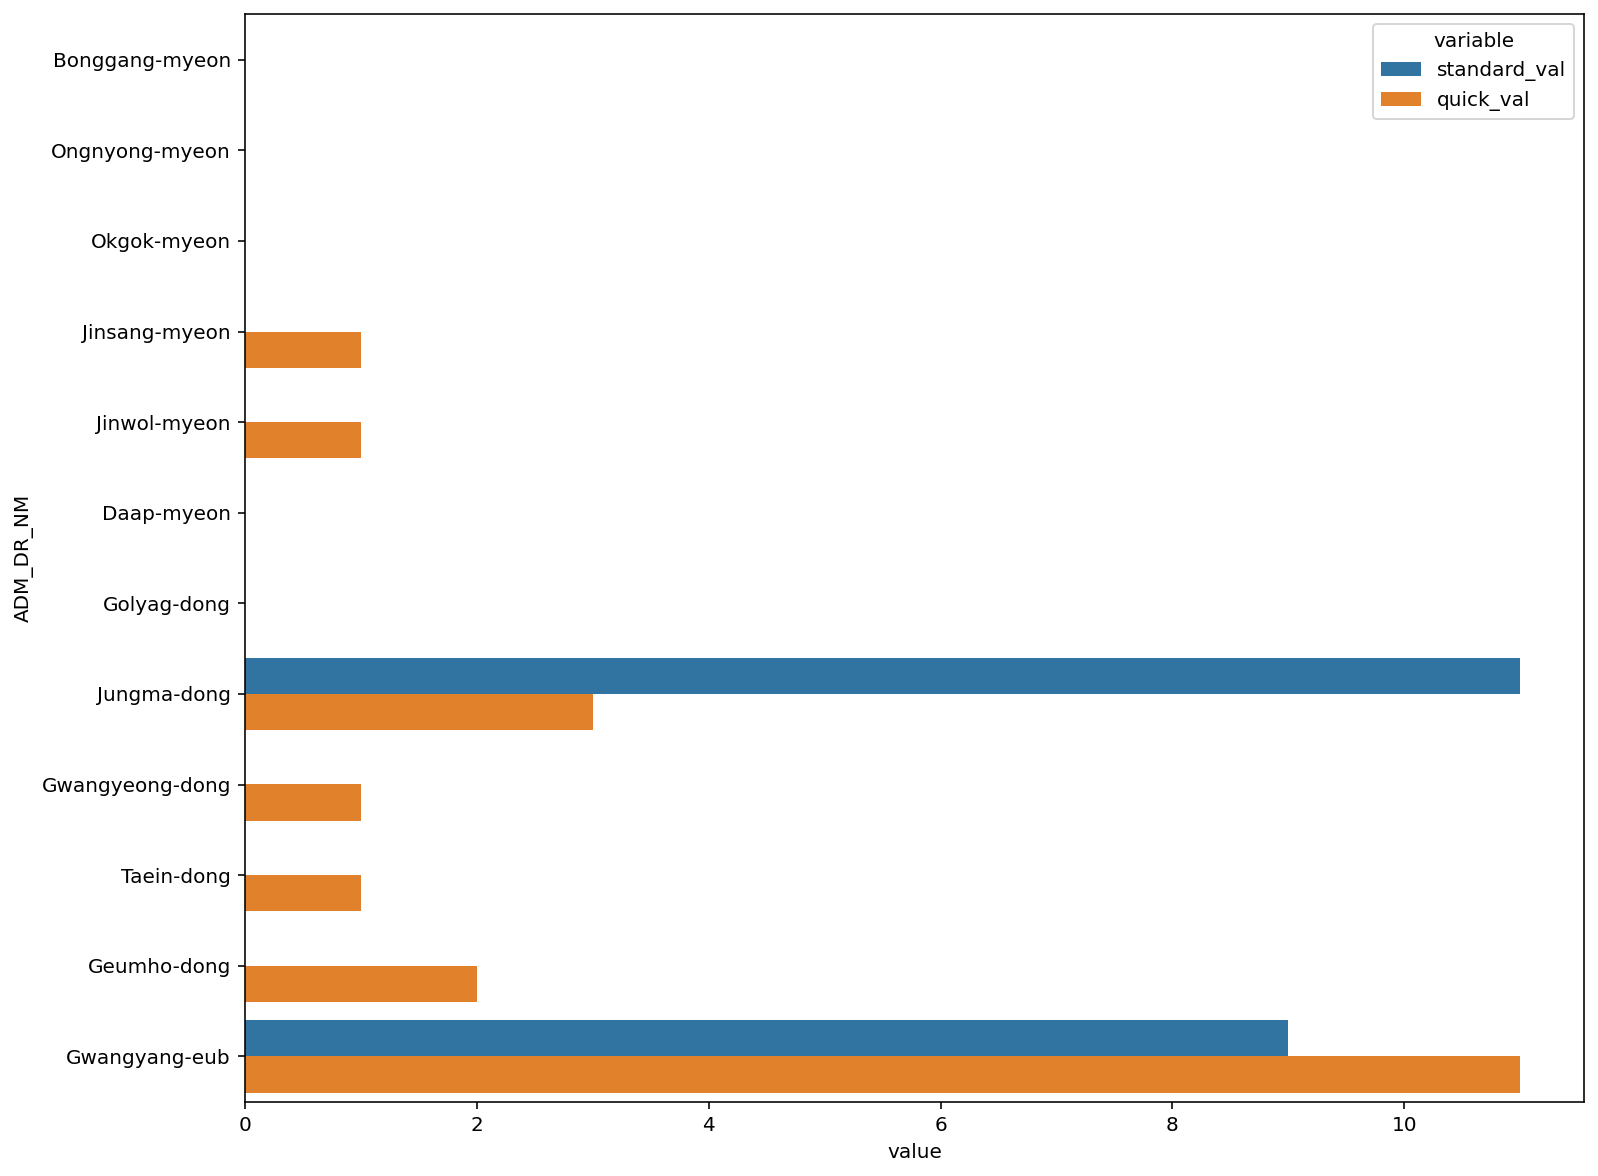

In [35]:
# 새롭게 설치될 충전소의 행정구역 시각화

plt.figure(figsize=(12, 10))
sns.barplot(data=행정경계, x='value', y='ADM_DR_NM', hue = 'variable', orient='h')
plt.show()

In [23]:
광양시_지도 = folium.Map(location = (34.940604, 127.695931),
                       zoom_start = 12,
                       tiles='http://api.vworld.kr/req/wmts/1.0.0/7C5AEFC9-57EF-35BD-A78A-74C1DD916554/Base/{z}/{y}/{x}.png',
               attr='My Data Attribution')

# 기 설치되어있는 충전소 circle마커로 시각화
for i in 충전소.index:
    popup_name = 충전소['충전소명'][i] + '-' + 충전소['급속/완속'][i]
    if 충전소['급속/완속'][i] == '급속':
        icon_color = 'red' # 급속: 빨강
    else:
        icon_color = 'blue' # 완속: 파랑
    
    folium.CircleMarker(
        location = (충전소['lat'][i], 충전소['lon'][i]),
        popup = popup_name,
        color = icon_color,
        radius = 5
    ).add_to(광양시_지도)

# 새롭게 설치된 충전소 마커로 시각화
for gid, geometry in standard_location.items():
    folium.Marker(
        location = (geometry[1][1], geometry[1][0]),
        popup = geometry[0],
        icon = folium.Icon(color='blue'),   # 완속: 파랑
    ).add_to(광양시_지도)

for gid, geometry in quick_location.items():
    folium.Marker(
        location = (geometry[1][1], geometry[1][0]),
        popup = geometry[0],
        icon = folium.Icon(color='red'),   # 급속: 빨강
    ).add_to(광양시_지도)

광양시_지도.save('완속급속20개.html')

In [61]:
# csv 파일로 변환

result = pd.DataFrame(columns = ['순번', 'X 좌표(경도)', 'Y 좌표(위도)', '충전소 구분'])
quick_item = list(quick_location.items())
standard_item = list(standard_location.items())

for i in range(40):
    if i%2:
        result.loc[i] = [i+1, standard_item[i//2][1][1][0], standard_item[i//2][1][1][1], '완속']
    else:
        result.loc[i] = [i+1, quick_item[i//2][1][1][0], quick_item[i//2][1][1][1], '급속']
result

,순번,X 좌표(경도),Y 좌표(위도),충전소 구분
0,1,127.575532,34.977103,급속
1,2,127.575324,34.965256,완속
2,3,127.590375,34.977016,급속
3,4,127.689775,34.933064,완속
4,5,127.577880,34.963578,급속
5,6,127.695428,34.936252,완속
6,7,127.696883,34.930593,급속
7,8,127.689898,34.944657,완속
8,9,127.607064,34.974006,급속
9,10,127.697416,34.933467,완속


In [64]:
# result.to_csv('result.csv', index = False, encoding = 'cp949')
result.to_csv('result.csv', index = False, encoding = 'utf8')